# Model, predict and solve the problem.

Our purpose is to identify factors affect Delivery time (Time_taken), so I will divide the model building into 2 parts:

- Part 1: build a multi-linear regression model with the purpose of determining the factors and the level of influence of each factor on delivery time, focusing on model interpretation.
- Part 2: build a model to predict delivery time

Before build model, we need to examine the correlation between the independent variables and the dependent variable. For continuous independent variables, we will use Pearson correlation and use Oneway-ANOVA with categorical variables to examine the difference between groups in a categorical variable, thereby assessing whether that variable is correlated with the dependent variable.

## Libraries

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
%matplotlib inline

## Loading data

In [2]:
df=pd.read_csv('data/modeling_data.csv')

## Feature Engineering
Feature engineering is a fundamental process of transforming raw data to make it more suitable for machine learning algorithms. Its purpose is to select, create, and modify features (input variables) to enhance the performance of a machine learning model.

### Cardinality
The values of a categorical variable are selected from a group of categories, also called labels. For example, in the variable gender the categories are male and female.

Categorical variables can contain different number of unique values. The variable "gender" contains only 2 labels, but another variable can contain a huge number of labels.

The number of different labels is known as cardinality. A high number of labels within a variable is known as high cardinality. High cardinality poses the following challenges:

- Variables with too many labels tend to dominate those with only a few labels, particularly in decision tree-based algorithms.
- High cardinality may introduce noise.
- Some of the labels may only be present in the training data set and not in the test set, so machine learning algorithms maybe over-fitting.
- Some labels may appear only in the test set, leaving the machine learning algorithms unable to perform a calculation over the new (unseen) observation.

Let's check cardinality of the Categorical Features.

In [3]:
df.select_dtypes(include='object').nunique()

Weatherconditions       6
Road_traffic_density    4
Type_of_order           4
Type_of_vehicle         2
Festival                2
City                    3
dtype: int64

### Rare Labels

Categorical variables are those whose values are selected from a group of categories, also called labels. Labels may have different frequencies. Some categories appear a lot in the dataset, some others appear only in a small number of observations.

More specifically, some chanllenges we may face when work with rare labels:

- Rare categories can cause over-fitting, particularly in tree-based methods.
- Infrequent labels may add noise, which could cause over-fitting.
- Rare labels may be present only in training or test set, therefore causing over-fitting or make the Machine Learning model don't know how to evaluate it.

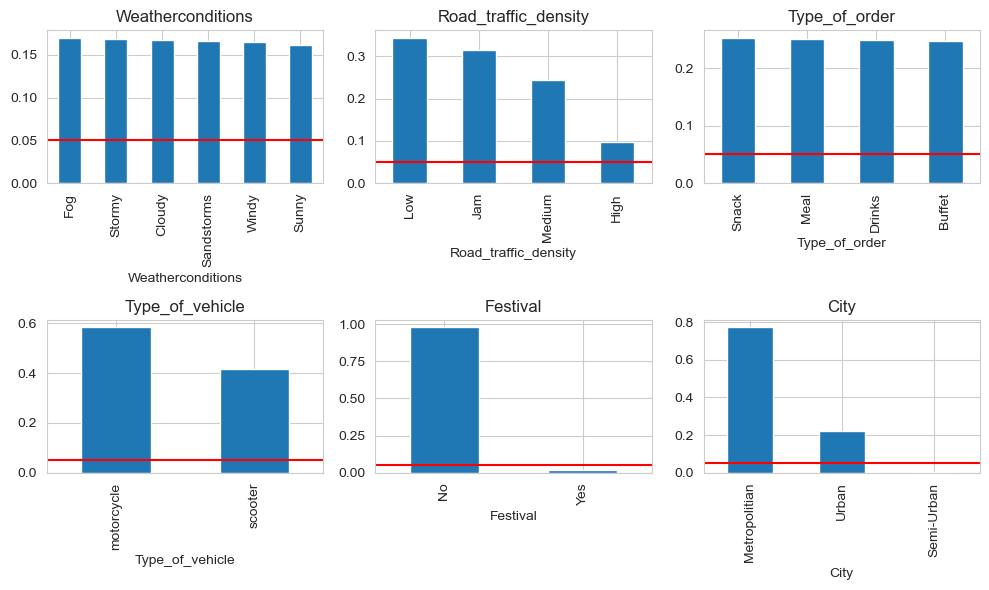

In [4]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))=plt.subplots(2, 3, figsize = (10, 6))

axes=[ax1, ax2, ax3, ax4, ax5, ax6]

# For each categorical variable
for ax, col in enumerate(df.select_dtypes(include='object').columns):
    pd.Series(df[col].value_counts()/len(df)).sort_values(ascending = False).plot(kind = 'bar', ax = axes[ax])
    axes[ax].set_title(col)
    axes[ax].axhline(y=0.05, color='red')

plt.tight_layout()

-  City and Festival both had a label that only appeared few times (Festival: Yes, City Semi-Urban) For festival I decided to remove the entire feature from the training dataset, since deliting "Yes" mean that there will be only "No" in the variable, this means having no predicting value. For city I decided to map those Semi-Urban as Urban.
-  Data was encoded using OneHot encoding since this is a regression problem.

**Festival**

In [5]:
df=df.drop(columns='Festival')

**City**

In [6]:
df['City']=df['City'].apply(lambda value: 'Urban' if value=='Semi-Urban' else value)

## Part 1
In this Part, I will focus on building a simple regression model (multi-linear regression) for two main reasons:
- We need a simple model to be able to identify the influencing factors as well as the level of impact of each factor.
- Because we need the interpretability of the model (such as how an increase or decrease of a variable will change the dependent variable) rather than prediction, choosing a model like Linear Regression is completely reasonable.

Before building the model, we will consider the correlation between the independent variables and the dependent variable. For categorical variables, ANOVA will be used to analyze the difference in means between groups, and for continuous variables, Pearson correlation will be used to assess the relationship with the dependent variable.

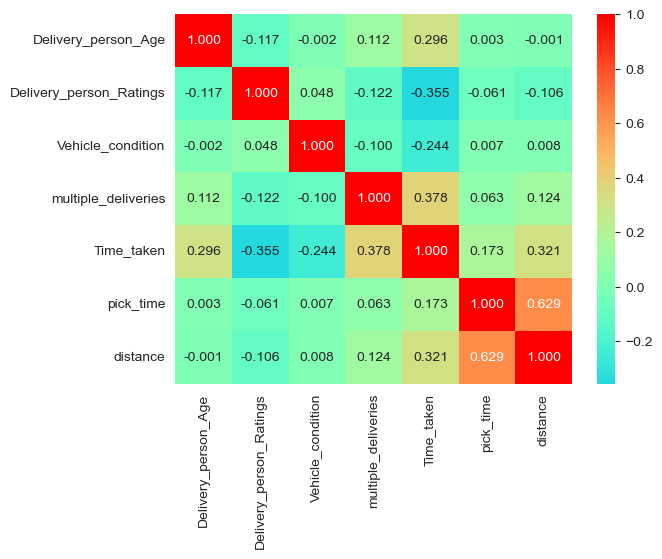

In [7]:
# Correlation matrix
corr=df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='rainbow', center=0, fmt='.3f');

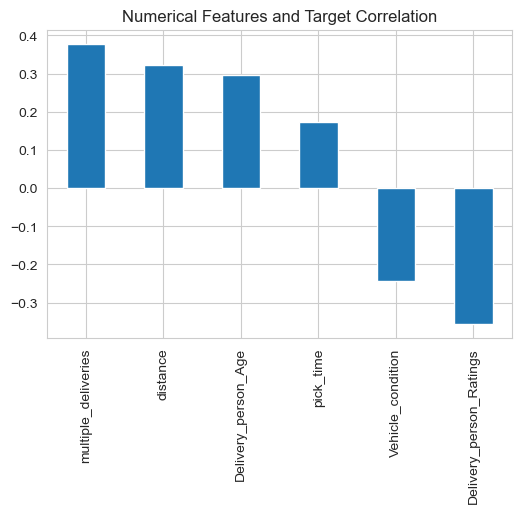

In [8]:
corr['Time_taken'].sort_values(ascending=False)[1:].plot(kind='bar', title = 'Numerical Features and Target Correlation', figsize = (6, 4));

With the above results, we see that most of the independent and dependent variables have an average correlation, in addition, there is a weak or very weak correlation between the independent variables to ensure that there is no multicollinearity phenomenon.

However, there is a high correlation between the two variables distance and pick_time (>0.5), which shows the possibility of multicollinearity, so we need to check VIF to evaluate the above possibility. It is still possible that although they are highly correlated with each other, this does not always negatively affect the model results.

In [9]:
# Analysis of Variance for categorical features
from scipy.stats import f_oneway
grouped_data={}
for col in df.select_dtypes(include='object').columns:
    grouped_data[col+'_grouped']=[group['Time_taken'].values for name, group in df.groupby(col)]
    f_statistic, p_value = f_oneway(*grouped_data[col + '_grouped'])
    print(f"Results for {col}:")
    print(f"F-statistic: {f_statistic:.4f}, P-value: {p_value:.4f}\n")

Results for Weatherconditions:
F-statistic: 607.6101, P-value: 0.0000

Results for Road_traffic_density:
F-statistic: 3403.6143, P-value: 0.0000

Results for Type_of_order:
F-statistic: 1.1453, P-value: 0.3292

Results for Type_of_vehicle:
F-statistic: 1273.7675, P-value: 0.0000

Results for City:
F-statistic: 1271.9722, P-value: 0.0000



For categorical variables, the ANOVA results show that except for the Type_of_order variable with p-value>0.5, the remaining variables show significant differences between groups in the categorical variables, from which it can be concluded that these variables are correlated with the dependent variable Time_taken. For the Type_of_order variable that has no correlation, we will remove it from the data.

In [10]:
df=df.drop(columns='Type_of_order')

### Feature Encoding
Feature encoding is important to convert non-numeric data into a numerical representation that machine learning algorithms can process. It ensures algorithm compatibility, preserves relevant information, reduces dimensionality, handles non-numeric data, and ultimately improves model performance.

There is too many Encoding techniques: OneHot, Ordinal, Frequency, Ordered, Mean, Weight of evidence, etc... It's worth noting that there is no one-size-fits-all encoding method, and the choice of encoding technique depends on the specific characteristics of the data, the machine learning algorithms being used, and the goals of the analysis. It is often helpful to experiment with different encoding approaches and evaluate their impact on the model's performance before deciding which one is most suitable for a particular classification problem.

For this particular case I have decided to use: **OneHot Encoding**.

In [11]:
df_encode=pd.get_dummies(data=df, columns=['Weatherconditions','Road_traffic_density', 'Type_of_vehicle', 'City'], dtype=int, drop_first=True)
df_encode.shape

(44900, 17)

In [12]:
# X y split
x=df_encode.drop(columns='Time_taken')
y=df_encode[['Time_taken']]

In [13]:
# Build model
import statsmodels.api as sm

x=sm.add_constant(x)
model=sm.OLS(y, x)
results=model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Time_taken   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     3656.
Date:                Sat, 04 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:15:21   Log-Likelihood:            -1.4550e+05
No. Observations:               44900   AIC:                         2.910e+05
Df Residuals:                   44883   BIC:                         2.912e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Feature Weatherconditions_Fog has p-value=0.889>0.05, so we will remove this variable from the model and run again.

In [14]:
# Drop Weatherconditions_Fog
x=df_encode.drop(columns=['Time_taken', 'Weatherconditions_Fog'])

x=sm.add_constant(x)
model=sm.OLS(y, x)
results=model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Time_taken   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     3900.
Date:                Sat, 04 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:15:21   Log-Likelihood:            -1.4550e+05
No. Observations:               44900   AIC:                         2.910e+05
Df Residuals:                   44884   BIC:                         2.912e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [15]:
coef=pd.DataFrame(results.params[1:], columns=['Coefficient'])

std_y=y.to_numpy().std()
std_x=x.iloc[:, 1:].std()

# Standardized coefficients
coef['Standardized Coefficient']=coef['Coefficient']*(std_x/std_y)
coef.reindex(coef['Standardized Coefficient'].abs().sort_values(ascending=False).index)

,Coefficient,Standardized Coefficient
Road_traffic_density_Low,-6.433194,-0.325681
Weatherconditions_Sunny,-6.447619,-0.253132
Delivery_person_Ratings,-7.576099,-0.249874
Delivery_person_Age,0.396997,0.242146
distance,0.388618,0.232241
Vehicle_condition,-2.309751,-0.201015
multiple_deliveries,3.216118,0.194488
Weatherconditions_Stormy,-3.017048,-0.120437
Weatherconditions_Sandstorms,-3.027771,-0.120264
Weatherconditions_Windy,-2.913171,-0.115283


**Interpretation of a Numerical Feature**

A 1-star increase in Delivery_person_Ratings reduces delivery time by about 7.6 minutes, all other features remain fixed. Similarly, a 1-km increase in distance increases delivery time by about 0.4 minutes, all other features remain fixed.

**Interpretation of a categorical feature**

Estimated delivery time is approximately 6.4 minutes lower at Road_traffic_density_Low than at Road_traffic_density_High, all other features remain fixed.

## Part 2
In this Part, I will focus on building a robust regression model to predict delivery time based on multiple variable.

### Data transformations
We apply data transformations for numerical feature only (Continious variables).

In [16]:
from scipy.stats import boxcox, yeojohnson

In [17]:
df.drop(columns=['Delivery_person_Age', 'Vehicle_condition', 'multiple_deliveries', 'pick_time', 'Time_taken']).select_dtypes(exclude=object).columns

Index(['Delivery_person_Ratings', 'distance'], dtype='object')

In [18]:
def check_dist(data, col):
    # Check and handle negative or 0 value before apply Log or Boxcox
    data_col=data[col]
    if (data_col<=0).any():
        print(f'Column {col} contains non-positive values, can not use Transformations like log and boxcox.')
        return

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))=plt.subplots(2, 3, figsize=(15, 8), sharey=False)
    
    # Original distribution
    sns.histplot(data=data, x=data_col, kde=True, bins=30, color='skyblue', ax=ax1)
    ax1.set_title(f'Original Distribution (Skewness: {data_col.skew():.5f})')

    # Log transformation
    log_transformed=np.log(data_col)
    sns.histplot(data=data, x=log_transformed, kde=True, bins=30, color='blue', ax=ax2)
    ax2.set_title(f'Log Transformation (Skewness: {log_transformed.skew():.5f})')

    # Square root transformation
    sqrt_transformed=np.sqrt(data_col)
    sns.histplot(data=data, x=sqrt_transformed, kde=True, bins=30, color='orange', ax=ax3)
    ax3.set_title(f'Square Root Transformation (Skewness: {sqrt_transformed.skew():.5f})')

    # Cube root transformation
    cbrt_transformed=np.cbrt(data_col)
    sns.histplot(data=data, x=cbrt_transformed, kde=True, bins=30, color='red', ax=ax4)
    ax4.set_title(f'Cube Root Transformation (Skewness: {cbrt_transformed.skew():.5f})')

    # Box-Cox transformation
    boxcox_transformed, _=boxcox(data_col)
    sns.histplot(x=boxcox_transformed, kde=True, bins=30, color='purple', ax=ax5)
    ax5.set_title(f'Box-Cox Transformation (Skewness: {pd.Series(boxcox_transformed).skew():.5f})')

    # Yeo-Johnson transformation
    yeojohnson_transformed, _=yeojohnson(data_col)
    sns.histplot(x=yeojohnson_transformed, kde=True, bins=30, color='green', ax=ax6)
    ax6.set_title(f'Yeo-Johnson Transformation (Skewness: {pd.Series(yeojohnson_transformed).skew():.5f})')
    
    plt.tight_layout()
    plt.show()

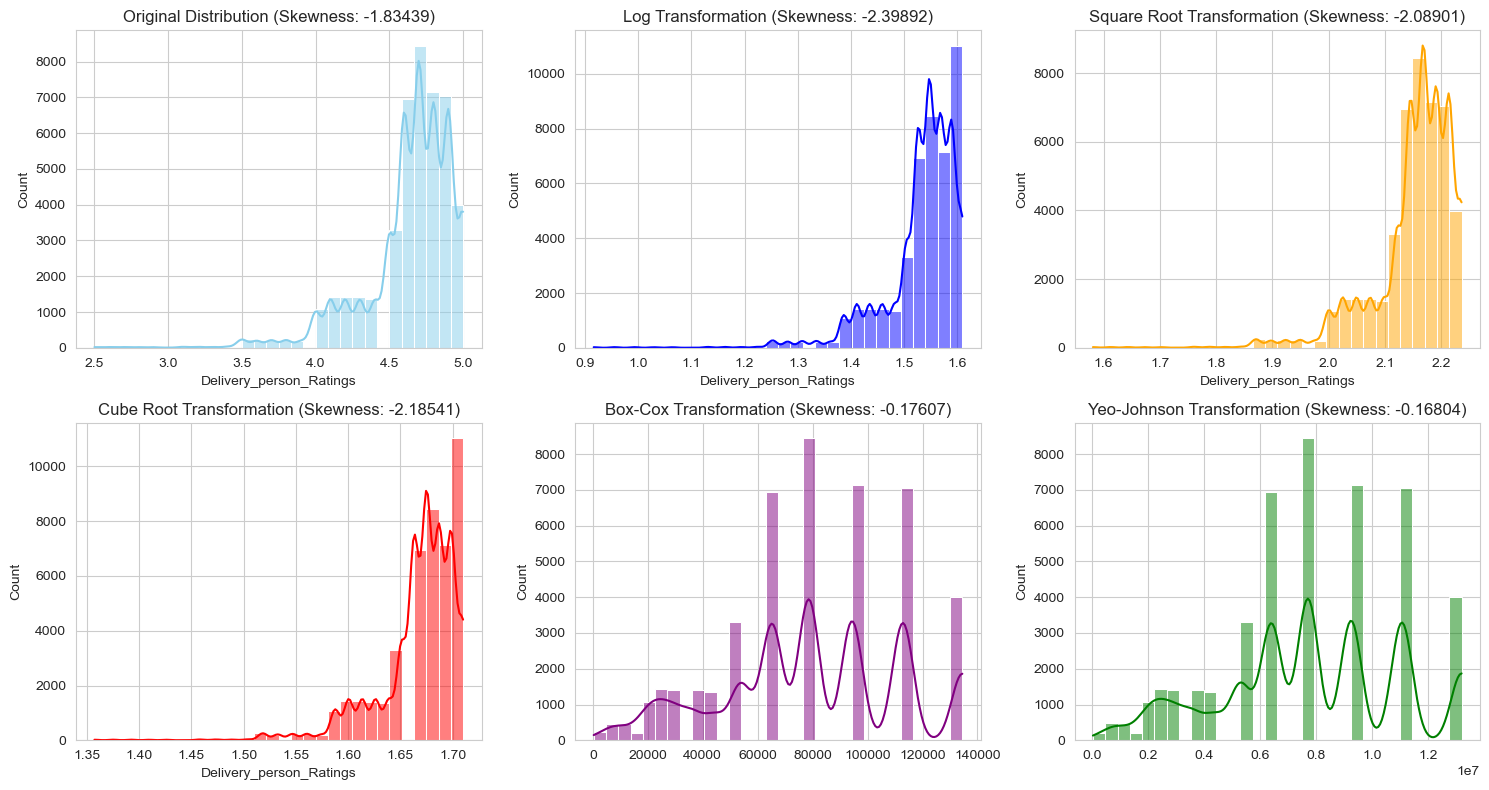

In [19]:
check_dist(df, 'Delivery_person_Ratings')

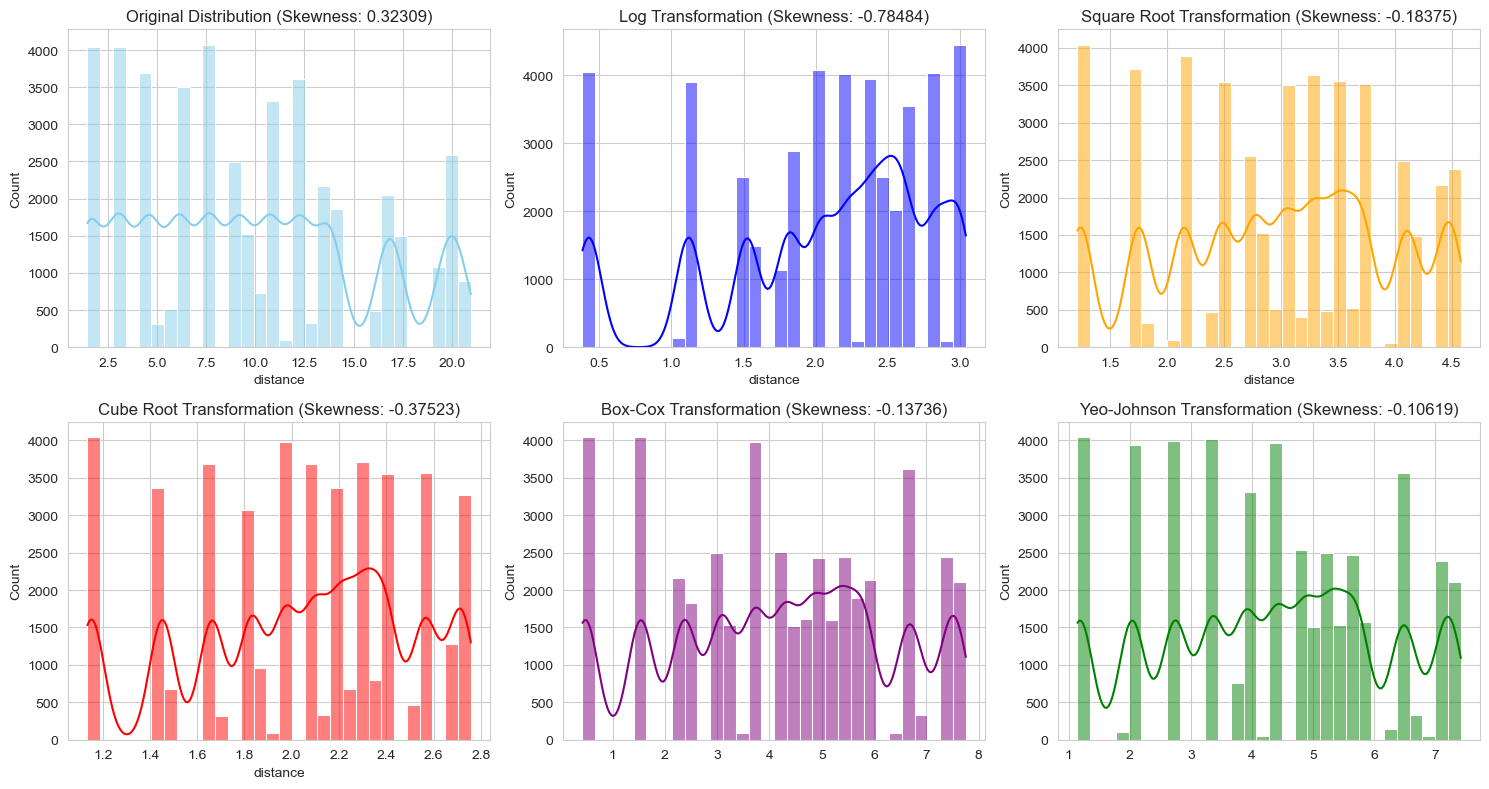

In [20]:
check_dist(df, 'distance')

**Notes:**

Although some transformations can reduce the skewness of the data, trying to bring the data to a normal or near normal distribution. However, this will be useful for some models such as linear regression,... The purpose of this section is to build a predictive model, so we will not be able to use simple models like Linear, instead we will use more complex models with higher accuracy such as RandomForest, XGBoost, LightGBM,... These models do not require the input data to have a normal distribution, in other words, they do not care about the shape of the data distribution. Therefore, in this case, we will not need to perform any transformations.

### X, y split

We can think of X as the input data, and y as the target values that we are trying to predict or model using machine learning algorithms. The goal is to learn a function or a relationship between X and y, so that given new input data, the model can make accurate prediction.

In [21]:
# Reseting Index
df.reset_index(drop=True, inplace=True)

In [22]:
X=df.drop(columns='Time_taken')
y=df['Time_taken']

### Performance & Error Metrics

Using performance and error metrics is essential for evaluating machine learning models. These metrics provide a quantitative assessment of model performance, aiding in model selection and hyperparameter tuning. They help detect overfitting or underfitting and enable performance monitoring over time. Metrics also play a crucial role in decision-making processes, allowing stakeholders to assess the feasibility and effectiveness of deploying ML models in real-world settings. Performance and error metrics provide a systematic and objective approach to evaluate and optimize ML models for optimal performance and decision-making.

The metrics I am gonna take into consideration are:

- **Mean Squared Error (MSE):** MSE is a common metric used to measure the average squared difference between the predicted and actual values in regression problems. It quantifies the overall quality of a regression model by assessing how closely its predictions align with the true values.
- **Root Mean Squared Error (RMSE):** RMSE is a commonly used evaluation metric in regression problems. It is derived from the Mean Squared Error (MSE) and provides a measure of the average magnitude of the prediction errors made by a regression model. To calculate RMSE, you take the square root of the MSE.
- **Mean Absolute Error (MAE):** MAE provides a measure of the average magnitude of the prediction errors made by the model. Unlike MSE and RMSE, which involve squaring the errors, MAE considers the absolute differences, which makes it less sensitive to outliers or instances with larger errors. The advantage of MAE is its simplicity and ease of interpretation. It represents the average absolute deviation from the true values and is expressed in the same units as the target variable.

Although all three of the above metrics are important, depending on the purpose of each problem, we should prioritize which metrics more. For the purpose of predicting delivery time, prioritizing metrics such as MAE and RMSE is necessary.

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

In [24]:
def get_metrics(y, y_pred):
    return {'MSE':mean_squared_error(y, y_pred),
            'RMSE':root_mean_squared_error(y, y_pred),
            'MAE':mean_absolute_error(y, y_pred)}

### Train-validation-test split

To ensure the generalizability of our machine learning algorithm, it is crucial to split the dataset into three segments: the training set, validation set, and test set. This will allow us to realistically measure our model’s performance by ensuring that the dataset used to train the model and the dataset used to evaluate it are distinct.

In [25]:
from sklearn.model_selection import train_test_split

# Split train-test from original data
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=1)

# Split validation-test from test data
X_val, X_test, y_val, y_test=train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [26]:
X_train.shape, X_val.shape, X_test.shape

((35920, 10), (4490, 10), (4490, 10))

In [27]:
for col in [X_train, X_val, X_test, y_train, y_val, y_test]:
    col.reset_index(drop=True, inplace=True)

### Data pre-processing

In [28]:
# Encoding data
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
encoder.fit(X_train[['Weatherconditions','Road_traffic_density', 'Type_of_vehicle', 'City']])

train_encoded=encoder.transform(X_train[['Weatherconditions','Road_traffic_density', 'Type_of_vehicle', 'City']])
validation_encoded=encoder.transform(X_val[['Weatherconditions','Road_traffic_density', 'Type_of_vehicle', 'City']])
test_encoded=encoder.transform(X_test[['Weatherconditions','Road_traffic_density', 'Type_of_vehicle', 'City']])

train_encoded=pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Weatherconditions','Road_traffic_density', 'Type_of_vehicle', 'City']))
validation_encoded=pd.DataFrame(validation_encoded, columns=encoder.get_feature_names_out(['Weatherconditions','Road_traffic_density', 'Type_of_vehicle', 'City']))
test_encoded=pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Weatherconditions','Road_traffic_density', 'Type_of_vehicle', 'City']))

In [29]:
# Combine encoded data to original data
X_train=pd.concat([X_train, train_encoded], axis=1).drop(columns=['Weatherconditions','Road_traffic_density', 'Type_of_vehicle', 'City'])
X_val=pd.concat([X_val, validation_encoded], axis=1).drop(columns=['Weatherconditions','Road_traffic_density', 'Type_of_vehicle', 'City'])
X_test=pd.concat([X_test, test_encoded], axis=1).drop(columns=['Weatherconditions','Road_traffic_density', 'Type_of_vehicle', 'City'])

In [30]:
X_train.shape, X_val.shape, X_test.shape

((35920, 16), (4490, 16), (4490, 16))

After splitting, we have about 36k rows for the train set, 4490 for each validation and test set.

In [31]:
# Scaling
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

X_train_sc=scaler.fit_transform(X_train)
X_val_sc=scaler.transform(X_val)
X_test_sc=scaler.transform(X_test)

X_train=pd.DataFrame(data=X_train_sc, columns=X_train.columns)
X_val=pd.DataFrame(data=X_val_sc, columns=X_val.columns)
X_test=pd.DataFrame(data=X_test_sc, columns=X_test.columns)

### Data training and validation

In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
from lazypredict.Supervised import LazyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
regressors=[('RandomForestRegressor', RandomForestRegressor),
              ('XGBRegressor', XGBRegressor),
              ('LGBMRegressor', LGBMRegressor),
              ('KNeighborsRegressor', KNeighborsRegressor)]

lazy_model=LazyRegressor(verbose=0, ignore_warnings=True, regressors=regressors, predictions='True', custom_metric=None)
reg_model, predictions=lazy_model.fit(X_train, X_val, y_train, y_val)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 50%|██████████████████████████████████████████                                          | 2/4 [00:12<00:10,  5.38s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 35920, number of used features: 16
[LightGBM] [Info] Start training from score 26.297188


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.50s/it]


In [34]:
reg_model.sort_values(by='RMSE', ascending=True)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.82,0.82,3.93,0.48
XGBRegressor,0.82,0.82,3.96,0.33
RandomForestRegressor,0.81,0.81,4.04,12.61
KNeighborsRegressor,0.75,0.76,4.60,0.58


After testing with 4 popular models, the results show that the LGBM Regressor model gives the lowest RMSE with default parameters. However, to improve this index, we will perform Hyperparameter tuning to optimize the model.

### Hyperparameters tuning

A Machine Learning model is defined as a mathematical model with several parameters that need to be learned from the data. By training a model with existing data, we can fit the model parameters. 
However, there is another kind of parameter, known as Hyperparameters, that cannot be directly learned from the regular training process. They are usually fixed before the actual training process begins. These parameters express important properties of the model such as its complexity or how fast it should learn. This article aims to explore various strategies to tune hyperparameters for Machine learning models

Hyperparameter tuning is the process of selecting the optimal values for a machine learning model’s hyperparameters. Hyperparameters are settings that control the learning process of the model, such as the learning rate, the number of neurons in a neural network, or the kernel size in a support vector machine. The goal of hyperparameter tuning is to find the values that lead to the best performance on a given task.

There are many methods to find the optimal parameter set for the model, such as GridSearch or RandomSearch, but the disadvantage of these two methods is that they both evaluate and optimize the model on the training set. This can cause over-fitting. To avoid that, we will build a way to find parameter sets based on ParameterGrid and use a for loop to run all parameter sets (similar to GridSearch) and test the results on the validation set. The goal is to find the parameter set that gives the best evaluation result on the validation set. 

In [35]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import ParameterGrid
def hyper_lgbm(X_train, X_val, y_train, y_val, params):
    
    results=[]

    for params in params:
        # print(f"Training with parameters: {params}")

        lgbm=LGBMRegressor(**params, verbose=-1)
        lgbm.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse'
        )
        
        y_pred=lgbm.predict(X_val)

        rmse=np.sqrt(mean_squared_error(y_val, y_pred))
        mae=mean_absolute_error(y_val, y_pred)
        
        result = params.copy()
        result['rmse']=rmse
        result['mae']=mae
        results.append(result)
        
    results_df=pd.DataFrame(results).sort_values(by='rmse', ascending=True).head(1)
    return results_df

There are quite a few parameters that can be adjusted, however we will use the 3 main parameters: learning_rate, max_depth and num_leaves. Tuning the hyperparameters by running this for loop can be time-consuming depending on the number of possible parameter combinations. The more combinations, the longer it will take to run. Instead, we can split each parameter value range into smaller ones to try.

In [36]:
# learning_rate, max_depth, num_leaves
param_grid={
    'learning_rate': np.arange(0.05, 0.15, 0.01),
    'num_leaves': np.arange(25,40, 1),
    'max_depth': [-1, 11, 1]
}

params=list(ParameterGrid(param_grid))
result_df=hyper_lgbm(X_train, X_val, y_train, y_val, params=params)
result_df

,learning_rate,max_depth,num_leaves,rmse,mae
417,0.14,-1,37,3.86,3.08


After tuning, we find a parameter set that gives a better rmse than the default (3.86 vs 3.93). Although this may not be the most optimal parameter set, we will assume that this is the optimal model (in reality we will have to do a lot of tuning to find the best model) so that we can move on to evaluating the model.

### Model performance evaluate

After obtaining the final model, we will test the model once on the test set and evaluate the model's ability to respond to an unseen dataset.

In [37]:
# Predict on test set
lgbm=LGBMRegressor(learning_rate=0.14, num_leaves=37, max_depth=-1, random_state=0)
lgbm.fit(X_train, y_train)
y_pred=lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 35920, number of used features: 16
[LightGBM] [Info] Start training from score 26.297188


In [38]:
from sklearn.metrics import explained_variance_score, max_error
summary=pd.DataFrame(get_metrics(y=y_test, y_pred=y_pred), index=['Score'])
summary['Explained Variance']=explained_variance_score(y_test, y_pred)
summary['Max Error']=max_error(y_test, y_pred)

summary

,MSE,RMSE,MAE,Explained Variance,Max Error
Score,15.41,3.93,3.16,0.82,17.44


After testing with the test set, the results show that the prediction model is quite good with RMSE = 3.93 and MAE = 3.16, this value does not deviate too much from the optimal result on the validation set.

In [39]:
compare_value=pd.DataFrame({
    'Real Value':y_test.values,
    'Model Prediction':y_pred.round(0),
    'Difference' : y_test.values-y_pred.round(0),
    'Difference %' : np.absolute((y_test.values-y_pred.round(0))/y_test.values * 100)})

compare_value.head()

,Real Value,Model Prediction,Difference,Difference %
0,25,22.00,3.00,12.00
1,15,17.00,-2.00,13.33
2,33,28.00,5.00,15.15
3,26,25.00,1.00,3.85
4,45,48.00,-3.00,6.67


In [40]:
compare_value.describe()

,Real Value,Model Prediction,Difference,Difference %
count,4490.00,4490.00,4490.00,4490.00
mean,26.35,26.38,-0.03,13.61
std,9.37,8.48,3.94,12.72
min,10.00,12.00,-17.00,0.00
25%,19.00,20.00,-3.00,5.26
50%,26.00,25.00,0.00,11.11
75%,32.00,33.00,3.00,18.41
max,54.00,52.00,16.00,141.67


Looking at the data statistics, we see that the results between the actual value and the predicted value are quite similar to each other. However, most of the models do quite well when most of the differences are less than 3 minutes. However, there is still a difference of up to 17 minutes compared to the actual value.

''

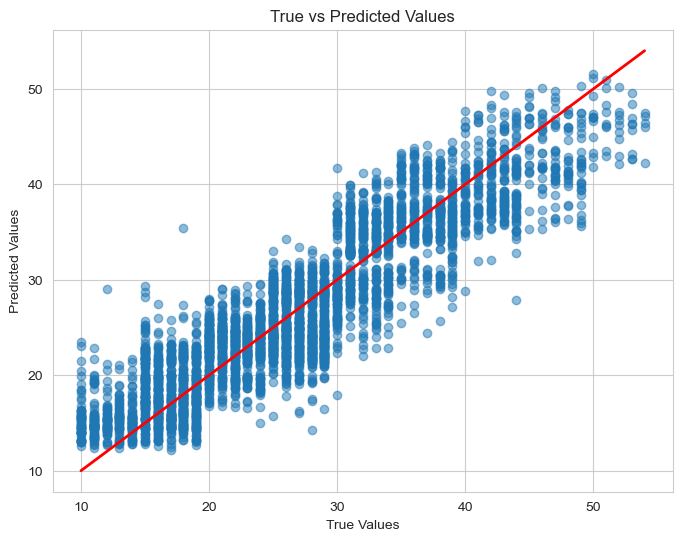

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
;

The above graph shows a comparison between the predicted values ​​and the actual values. The results show that the values ​​are quite close to the diagonal (the diagonal y=x shows the match between the predicted values ​​and the actual values). In addition, the distribution of the points is quite even and random around the diagonal, which shows that the model has good generalization ability.

''

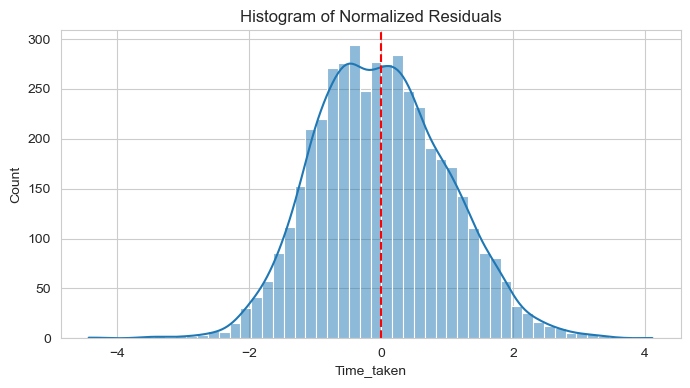

In [42]:
residuals=y_test-y_pred
normalized_residuals=(residuals-np.mean(residuals))/np.std(residuals)

plt.figure(figsize=(8, 4))
sns.histplot(normalized_residuals, kde=True)
plt.title('Histogram of Normalized Residuals')
plt.axvline(0, color='red', linestyle='--')
;

The above graph is used to evaluate the normal distribution of the residuals. It can be seen that the residuals have approximately normal distribution when they have a bell shape around the 0 axis, thereby showing that the hypothesis of a normally distributed residual model is not violated, ensuring the model is suitable.

''

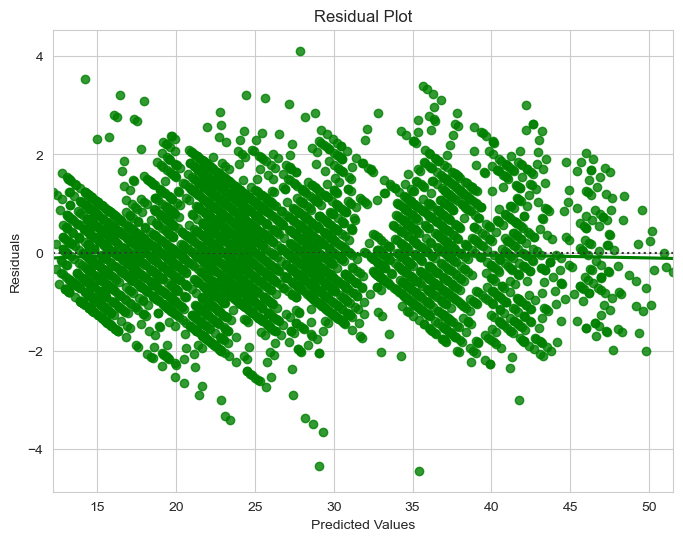

In [43]:
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=normalized_residuals, lowess=True, color="g")
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
;

The above graph helps to evaluate the validity of the model and identify potential problems. One of the assumptions of regression is homoscedasticity. This means that the dispersion of the residuals does not change with the predicted values. With the above results, the values ​​are around the horizontal line 0 and there is no increasing or decreasing trend, indicating that the model is performing well. However, the results also show that there are still some outliers that should be removed to achieve better results.

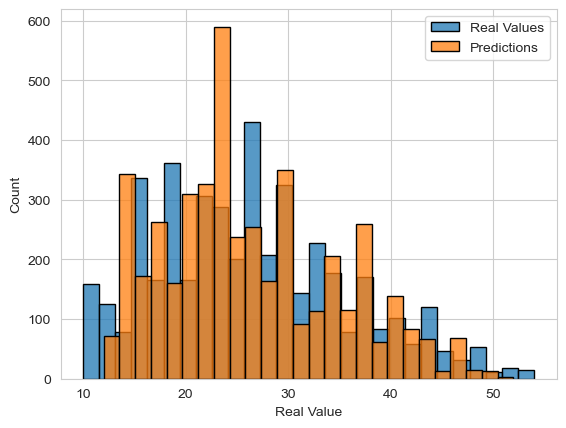

In [44]:
sns.histplot(data=compare_value, x='Real Value', label='Real Values', edgecolor = 'k')
sns.histplot(data=compare_value, x='Model Prediction', label='Predictions', edgecolor = 'k')
plt.legend();

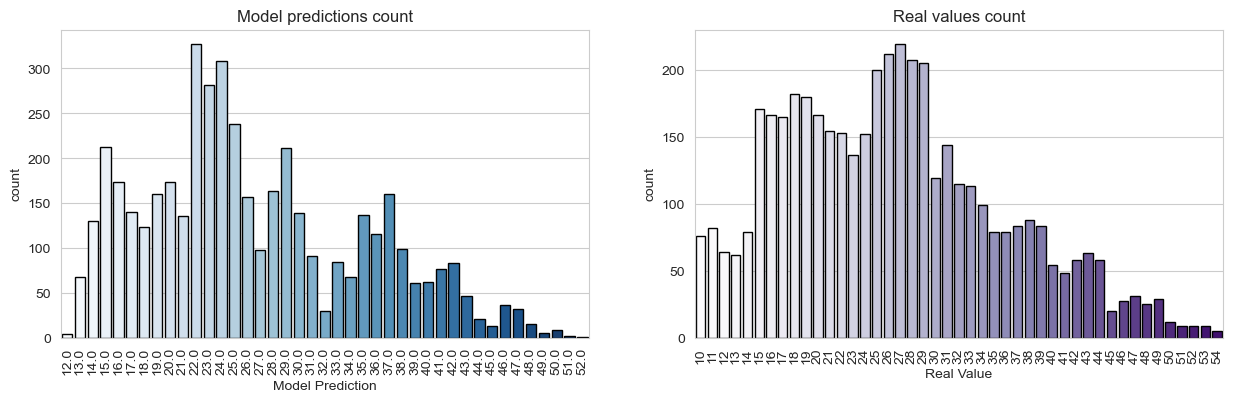

In [45]:
fig, (ax1, ax2)=plt.subplots(1, 2,figsize = (15, 4))
sns.countplot(data=compare_value, x='Model Prediction', ax=ax1, edgecolor='k', palette='Blues', hue='Model Prediction', legend=False)
ax1.set_title('Model predictions count')
sns.countplot(data=compare_value, x='Real Value', ax=ax2, edgecolor='k', palette='Purples', hue='Real Value', legend=False)
ax2.set_title('Real values count')

for ax in [ax1, ax2]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

The distribution of values ​​between actual and predicted are quite similar to each other.

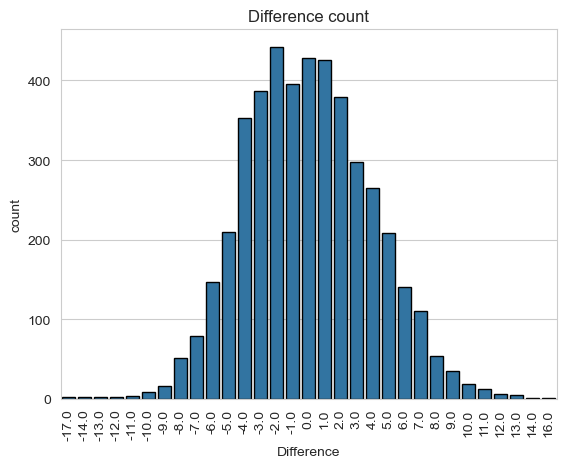

In [46]:
sns.countplot(data=compare_value, x='Difference', edgecolor='k')
plt.xticks(rotation=90)
plt.title('Difference count');

In [47]:
# Save model
import joblib
joblib.dump(lgbm, 'lgbm_model.pkl')

['lgbm_model.pkl']

In [48]:
# Save data
X_train.to_csv('data/X_train.csv', index = False, encoding = 'utf-8')
X_val.to_csv('data/X_validation.csv', index = False, encoding = 'utf-8')
X_test.to_csv('data/X_test.csv', index = False, encoding = 'utf-8')
y_train.to_csv('data/y_train.csv', index = False, encoding = 'utf-8')
y_val.to_csv('data/y_validation.csv', index = False, encoding = 'utf-8')
y_test.to_csv('data/y_test.csv', index = False, encoding = 'utf-8')